In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from matplotlib.animation import PillowWriter
from Tryba_Functions import scatter_with_subplots

# Data Import

In [2]:
# create dataframe
time_tracking = pd.read_csv('time_tracking.csv')

# change date columns to datetime
time_tracking['datetime'] = time_tracking['datetime'].astype('datetime64[s]')

# Add days of week, week #, and year columns to time_tracking
time_tracking['day_of_week'] = time_tracking['datetime'].dt.day_name() 
time_tracking['year'] = time_tracking['datetime'].dt.year
time_tracking['week'] = time_tracking['datetime'].dt.isocalendar().week

# Exploratory Analysis

## Time Management Analysis

### Length of Productivity Sessions

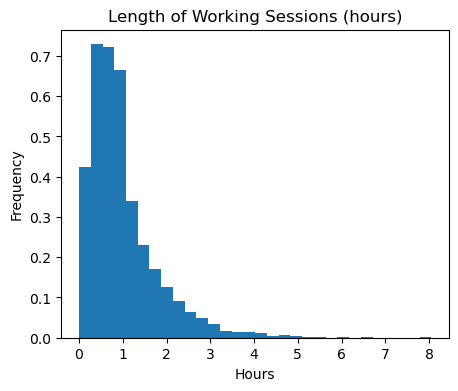

In [ ]:
column_data = time_tracking['hours']
plt.figure(figsize=(5,4))
plt.hist(column_data, density=True, bins= 30)
title = 'Length of Working Sessions (hours)'
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title(title)
plt.savefig(os.path.join('Visualizations', title))
plt.show()

### Total Hours Separated by Activity

In [ ]:
# Filter business activities from tracking input
business_activities = ['Client Production', 'Meridian Quake', 'Spec', 'Admin', 'Sound Design', 'Engineering', 
                       'Practicing', 'Edu Data Science']
time_tracking_business = time_tracking[time_tracking['activity'].isin(business_activities)]

# sum total business hours by activity type
activity_total_hours = time_tracking_business.groupby('activity').hours.sum().reset_index(name='total_hours')
activity_total_hours = activity_total_hours.sort_values(by='total_hours', ascending=False)
activity_total_hours.head(20)

,activity,total_hours
1,Client Production,4187.94
4,Meridian Quake,1555.38
7,Spec,1049.80
0,Admin,720.57
6,Sound Design,231.35
3,Engineering,224.02
2,Edu Data Science,157.15
5,Practicing,128.42


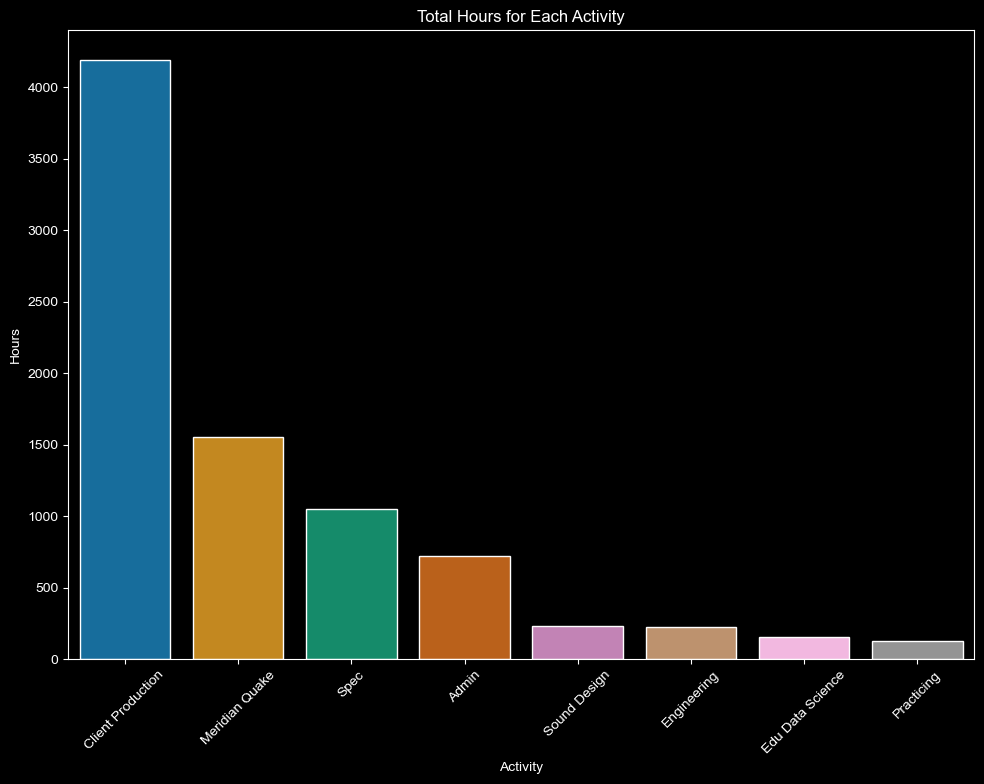

In [ ]:
# create figure
plt.figure(figsize=(10,8))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(activity_total_hours))

# Create the bar plot with the chosen palette
sns.barplot(x='activity', y='total_hours', data=activity_total_hours, palette=palette)
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Hours')
title = 'Total Hours for Each Activity'
plt.title(title)
plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.savefig(os.path.join('Visualizations', title))
plt.show()

### Productivity By Day of Week

In [ ]:
# Filter business activities from tracking input
business_activities = ['Client Production', 'Meridian Quake', 'Spec', 'Admin']

# Filter the years to be greater than 2016 and less than the current year
current_year = datetime.datetime.now().year
unique_years_temp = time_tracking[(time_tracking['activity'].isin(business_activities)) 
                                                & (time_tracking['year'] < current_year) 
                                                & (time_tracking['year'] > 2016)]

# Create list of years
years_list = unique_years_temp['year'].unique().tolist()
print(years_list)

[2017, 2018, 2019, 2020, 2021, 2022]


#### Creating gifs of actvities by week and by year

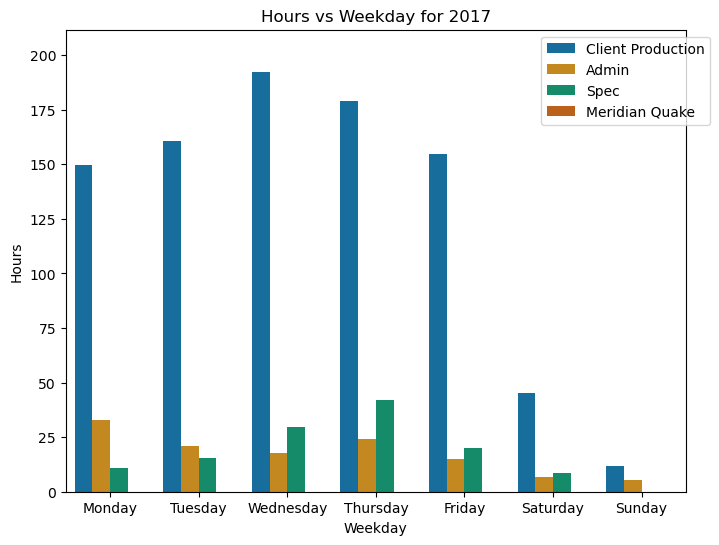

In [ ]:
# Create writer and meta data
metadata = dict(title='movie', artist ='Matthew Tryba')
writer = PillowWriter(fps=0.5, metadata=metadata)
title = 'Weekday Activity Changes by Year'
filepath = os.path.join('Visualizations', title + '.gif')

# Initialize the figure and axes outside of the loop
fig, ax = plt.subplots(figsize=(8,6))

with writer.saving(fig, filepath, 100):
    max_hours = 0

    for year in years_list:
        # Filter dataframe by year
        time_tracking_by_year = time_tracking[time_tracking['year'] == year]

         # Create a pivot table with day_of_week as index, activity as columns, and hours as values
        pivot_data = time_tracking_by_year.pivot_table(index='day_of_week', columns='activity', values='hours', aggfunc='sum')

        # Ensure all activities are present by reindexing
        pivot_data = pivot_data.reindex(columns=business_activities, fill_value=0).reset_index()

        # Melt the data to get it back to long format for plotting
        plot_data = pivot_data.melt(id_vars='day_of_week', value_name='hours', var_name='activity')
        
        # Find the max hours for y axis
        if plot_data['hours'].max() > max_hours:
            max_hours = plot_data['hours'].max() * 1.1

        # Sort by days_of_week
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plot_data['day_of_week'] = pd.Categorical(plot_data['day_of_week'], categories=days_order, ordered=True)
        plot_data = plot_data.sort_values('day_of_week')
        
        # Clear the current axes (necessary to avoid overlapping plots)
        ax.clear()
        
        # Create barplots for each year
        sns.barplot(x='day_of_week', y='hours', hue='activity', data=plot_data, ax=ax, palette='colorblind')
        ax.set_title(f'Hours vs Weekday for {year}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        ax.set_ylim(0, max_hours)
        ax.set_xlabel('Weekday')
        ax.set_ylabel('Hours')
        
        writer.grab_frame()
        plt.show()



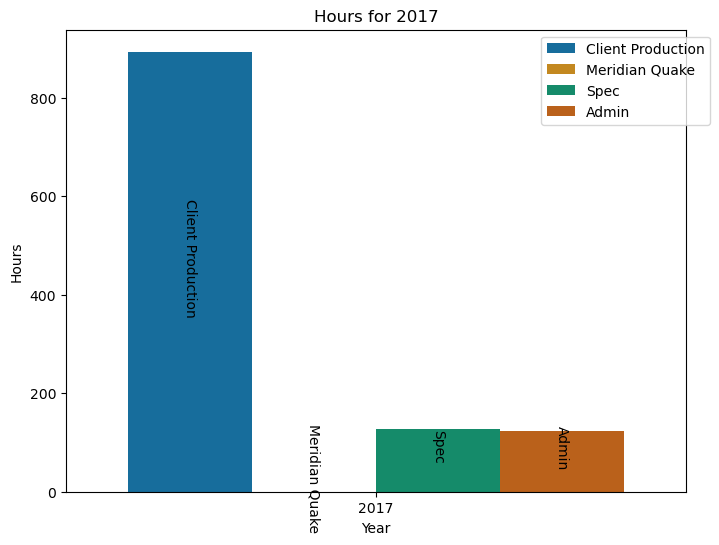

In [ ]:
# Create writer and meta data
metadata = dict(title='movie', artist ='Matthew Tryba')
writer = PillowWriter(fps=0.5, metadata=metadata)
title = 'Activity Changes by Year'
filepath = os.path.join('Visualizations', title + '.gif')

# Initialize the figure and axes outside of the loop
fig, ax = plt.subplots(figsize=(8,6))

with writer.saving(fig, filepath, 100):
    max_hours = 0

    for year in years_list:
        # Filter dataframe by year
        time_tracking_by_year = time_tracking[time_tracking['year'] == year]

         # Create a pivot table with day_of_week as index, activity as columns, and hours as values
        pivot_data = time_tracking_by_year.pivot_table(index='year', columns='activity', values='hours', aggfunc='sum')

        # Ensure all activities are present by reindexing
        pivot_data = pivot_data.reindex(columns=business_activities, fill_value=0).reset_index()
        
        # Melt the data to get it back to long format for plotting
        plot_data = pivot_data.melt(id_vars='year', value_name='hours', var_name='activity')
        
        # Find the max hours for y axis
        if plot_data['hours'].max() > max_hours:
            max_hours = plot_data['hours'].max() * 1.1
        
        # Clear the current axes (necessary to avoid overlapping plots)
        ax.clear()
        
        # Create barplots for each year
        sns.barplot(x='year', y='hours', hue='activity', data=plot_data, ax=ax, palette= 'colorblind')
        ax.set_title(f'Hours for {year}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        #ax.set_ylim(0, max_hours)

        # Add hue values inside the bars
        for p, label in zip(ax.patches, plot_data['activity']):
            ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points', rotation=270)
        ax.set_xlabel('Year')
        ax.set_ylabel('Hours')
        writer.grab_frame()
        plt.show()
